# exp041

pageごとのtime_diff数

In [1]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from collections import defaultdict

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
@dataclass
class Cfg:
    mode = "local_cv" # "local_cv" or "kaggle_inf" 
    exp_name = "exp041"
    input_dir = "/mnt/predict-student-performance-from-game-play/input/"
    output_dir = "/mnt/predict-student-performance-from-game-play/output/"
    prep_dir = "/mnt/predict-student-performance-from-game-play/prep/"
    seed = 42
    n_splits = 5
    best_threshold = 0.630 # local_cvの結果を入れる
cfg = Cfg()

if cfg.mode == "local_cv":
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)

elif cfg.mode == "kaggle_inf":
    import jo_wilder

In [3]:
params = {
    'objective': 'binary', 
    'boosting': 'gbdt', 
    'learning_rate': 0.01, 
    'metric': 'binary_logloss', 
    'seed': cfg.seed, 
    'feature_pre_filter': False, 
    'lambda_l1': 3.86172588734434e-05, 
    'lambda_l2': 8.164200511365216, 
    'num_leaves': 31, 
    'feature_fraction': 0.4, 
    'bagging_fraction': 0.9437148886789388, 
    'bagging_freq': 1, 
    'min_child_samples': 50
}

In [4]:
features_used_total = [
    'record_cnt'
]

In [5]:
level_group_list = ['0-4', '5-12', '13-22']

event_name_list = [
    'cutscene_click', 'person_click', 'navigate_click',
    'observation_click', 'notification_click', 'object_click',
    'object_hover', 'map_hover', 'map_click', 'checkpoint',
    'notebook_click'
]

name_list = [
    'basic', 'undefined', 'close', 'open', 'prev', 'next'
]

page_list = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]  

level_list = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
               17, 18, 19, 20, 21, 22]

room_fqid_list = ['tunic.historicalsociety.closet',
 'tunic.historicalsociety.basement',
 'tunic.historicalsociety.entry',
 'tunic.historicalsociety.collection',
 'tunic.historicalsociety.stacks',
 'tunic.kohlcenter.halloffame',
 'tunic.capitol_0.hall',
 'tunic.historicalsociety.closet_dirty',
 'tunic.historicalsociety.frontdesk',
 'tunic.humanecology.frontdesk',
 'tunic.drycleaner.frontdesk',
 'tunic.library.frontdesk',
 'tunic.library.microfiche',
 'tunic.capitol_1.hall',
 'tunic.historicalsociety.cage',
 'tunic.historicalsociety.collection_flag',
 'tunic.wildlife.center',
 'tunic.flaghouse.entry',
 'tunic.capitol_2.hall']

In [6]:
def transform_labels_df(labels_):
    """
    labelsデータを整形する
    """
    labels = labels_.copy()
    labels["question"] = labels["session_id"].apply(lambda x: x.split("_")[1].replace("q", "")).astype(int)
    labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)
    
    # trainの特徴量と結合するためにquestionに対応するlabel_groupを列として設けておく
    labels["level_group"] = ""
    labels.loc[labels["question"]<=3, "level_group"] = "0-4"
    labels.loc[(labels["question"]>=4)&(labels["question"]<=13), "level_group"] = "5-12"
    labels.loc[labels["question"]>=14, "level_group"] = "13-22"

    return labels

In [7]:
class Features:
    def __init__(self, _sessions):
        self.sessions = _sessions.copy()
        self.features = self.sessions[["session_id", "level_group"]].drop_duplicates().copy()

    def _prep(self):
        self.sessions = self.sessions.sort_values(["session_id", "level_group", "elapsed_time"], ignore_index=True)
        self.sessions["elapsed_time_diff"] = self.sessions["elapsed_time"] - self.sessions.groupby(["session_id", "level_group"])["elapsed_time"].shift(1)

    def _record_cnt(self):
        """level_groupごとのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":"record_cnt"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _event_name_record_cnt(self):
        """level_groupごと、各event_nameのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for event in event_name_list:
            new_col = f"{event}_record_cnt"
            tmp = add_features[add_features["event_name"]==event][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _name_record_cnt(self):
        """level_groupごと、各nameのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for name in name_list:
            new_col = f"{name}_record_cnt"
            tmp = add_features[add_features["name"]==name][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _page_record_cnt(self):
        """level_groupごと、各pageのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "page"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for page in page_list:
            new_col = f"page{str(int(page))}_cnt"
            tmp = add_features[add_features["page"]==page][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _room_fqid_record_cnt(self):
        """level_groupごと、各room_fqidのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "room_fqid"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for room in room_fqid_list:
            new_col = f"{room}_cnt"
            tmp = add_features[add_features["room_fqid"]==room][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _level_record_cnt(self):
        """各levelのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "level"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for level in level_list:
            new_col = f"level{str(int(level))}_cnt"
            tmp = add_features[add_features["level"]==level][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _elapsed_time(self):
        """level_groupごと、epapsed_timeのmax - min（経過時間）
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])["elapsed_time"].agg([max,min]).reset_index()
        add_features["elapsed_time"] = add_features["max"] - add_features["min"]
        add_features = add_features[["session_id", "level_group", "elapsed_time"]].copy()
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _coor_mean(self):
        """level_groupごと、座標系の平均値
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])[["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]].mean().reset_index()
        add_features = add_features.rename(columns={"room_coor_x":"room_coor_x_mean", "room_coor_y":"room_coor_y_mean", "screen_coor_x":"screen_coor_x_mean", "screen_coor_y":"screen_coor_y_mean"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _event_name_coor_mean(self):
        """level_groupごと、evemt_nameごとの座標系の平均値
        """
        coor_cols = ["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])[coor_cols].mean().reset_index()
        for event in event_name_list:
            if event in ['checkpoint', 'map_hover', 'object_hover']:
                # これらのデータには座標データが存在しないので特徴量化をスキップ
                continue
            col_map = {col:f"{event}_elapsed_{col}_mean" for col in coor_cols}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["event_name"]==event].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["event_name"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1

    def _name_coor_mean(self):
        """level_groupごと、nameごとの座標系の平均値
        """
        coor_cols = ["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]
        add_features = self.sessions.groupby(["session_id", "level_group", "name"])[coor_cols].mean().reset_index()
        for name in name_list:
            col_map = {col:f"{name}_elapsed_{col}_mean" for col in coor_cols}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["name"]==name].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["name"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1

    def _cat_col_nunique(self, col):
        """level_groupごと、[col]のユニーク数
        """
        add_features = self.sessions.dropna(subset=[col]).drop_duplicates(["session_id", "level_group", col])
        add_features = add_features.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":f"{col}_nunique"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _elapsed_time_diff_agg(self):
        """level_groupごと、前後のレコードのelapsed_timeの差分に関する集計量
        """
        add_features = self.sessions.copy()
        add_features = add_features.groupby(["session_id", "level_group"])["elapsed_time_diff"].agg(["max", "min", "mean", "std"]).reset_index()
        add_features = add_features.rename(columns={"max":"elapsed_time_diff_max", "min":"elapsed_time_diff_min", "mean":"elapsed_time_diff_mean", "std":"elapsed_time_diff_std"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _event_name_elapsed_time_diff_agg(self, agg):
        """level_group、event_nameごとelapsed_timeの差分に関する集計量
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])["elapsed_time_diff"].agg(agg).reset_index()
        for event in event_name_list:
            col_map = {a:f"{event}_elapsed_time_diff_{a}" for a in agg}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["event_name"]==event].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["event_name"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1

    def _room_fqid_elapsed_time_diff_agg(self, agg):
        """level_group、room_fqidごとelapsed_timeの差分に関する集計量
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "room_fqid"])["elapsed_time_diff"].agg(agg).reset_index()
        for room in room_fqid_list:
            col_map = {a:f"{room}_elapsed_time_diff_{a}" for a in agg}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["room_fqid"]==room].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["room_fqid"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1

    def _page_elapsed_time_diff_agg(self, agg):
        """level_group、pageごとelapsed_timeの差分に関する集計量
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "page"])["elapsed_time_diff"].agg(agg).reset_index()
        for page in page_list:
            col_map = {a:f"page{str(int(page))}_elapsed_time_diff_{a}" for a in agg}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["page"]==page].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["page"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1
                
    def _hover_duration_agg(self, agg):
        """level_groupごと、前後のレコードのelapsed_timeの差分に関する集計量
        """
        col_map = {a:f"hover_duration_{a}" for a in agg}
        add_features = self.sessions.copy()
        add_features = add_features.groupby(["session_id", "level_group"])["hover_duration"].agg(agg).reset_index()
        add_features = add_features.rename(columns=col_map)
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")


    def get_features(self):
        self._prep()
        self._record_cnt()
        self._event_name_record_cnt()
        self._name_record_cnt()
        self._elapsed_time()
        self._coor_mean()
        self._cat_col_nunique("text")
        self._elapsed_time_diff_agg()
        self._event_name_elapsed_time_diff_agg(["mean", "max", "min", "std"])
        self._event_name_coor_mean()
        self._name_coor_mean()
        self._page_record_cnt()
        self._hover_duration_agg(["mean", "max", "min", "std"])
        self._level_record_cnt()
        self._room_fqid_elapsed_time_diff_agg(["mean", "max", "min", "std"])
        self._room_fqid_record_cnt()
        self._page_elapsed_time_diff_agg(["mean", "max", "min", "std"])
        return self.features

In [8]:
class History:
    def __init__(self):
        self.store = {}
        for c in features_used_total:
            self.store[c] = defaultdict(int)

    def record(self, train):
        df = train.drop_duplicates("session_id").set_index("session_id")[features_used_total]
        for session in df.index:
            for c in features_used_total:
                self.store[c][session] += df.at[session, c]

    def add_total_features(self, train):
        for c in features_used_total:
            train[f"total_{c}"] = train["session_id"].map(self.store[c])
        return train

In [9]:
def calc_metrics(oof):
    logloss = log_loss(oof["correct"], oof["pred"])

    # find best th
    scores = []; thresholds = []
    best_score = 0; best_threshold = 0

    for threshold in np.arange(0.4,0.81,0.01):
        preds = (oof["pred"].values>threshold).astype(int)
        m = f1_score(oof["correct"].values, preds, average='macro')   
        scores.append(m)
        thresholds.append(threshold)
        if m>best_score:
            best_score = m
            best_threshold = threshold
    print("logloss", format(logloss, ".6f"))
    print("best_score", format(best_score, ".6f"))
    print("best_threshold", format(best_threshold, ".3f"))

    # Q別スコア
    print("---"*10)
    for q in range(18):
        q = q + 1
        preds = (oof[oof["question"]==q]["pred"].values>threshold).astype(int)
        m = f1_score(oof[oof["question"]==q]["correct"].values, preds, average='macro')
        print(f"Q{q} : F1 = {format(m, '.6f')}")
    return best_threshold

In [10]:
def get_train_data(sessions, labels, hist):
    # labelデータの整形
    labels = transform_labels_df(labels)

    # 特徴量生成
    feat = Features(sessions)
    features = feat.get_features()
    
    train = features.merge(labels, on=["session_id", "level_group"], how="left")
    train["level_group"] = train["level_group"].map({"0-4":0, "5-12":1, "13-22":2}).astype("category")
    train["question"] = train["question"].astype("category")

    # level_groupの特徴量記録＆過去のgroup含めたtotal値の特徴量取得
    hist.record(train)
    train = hist.add_total_features(train)

    return train, hist

In [11]:
def run_train():
    dfs = []
    hist = History()
    for group in level_group_list:
        # データ読み込み
        train_sessions = pd.read_csv(cfg.prep_dir + f"train{group}.csv")
        labels = pd.read_csv(cfg.prep_dir + f"train_labels{group}.csv")
        train_group, hist = get_train_data(train_sessions, labels, hist)
        dfs.append(train_group)
    train = pd.concat(dfs, ignore_index=True)
    # concatするとcategory型がリセットされてしまうので再度cast
    train["level_group"] = train["level_group"].astype("category")
    train["question"] = train["question"].astype("category")

    target = "correct"
    not_use_cols = [target, "session_id", "level_group"]
    features = [c for c in train.columns if c not in not_use_cols]

    gkf = GroupKFold(n_splits=cfg.n_splits)
    fis = []
    oofs = []
    for i, (tr_idx, vl_idx) in enumerate(gkf.split(train[features], train[target], train["session_id"])):
        print(f"fold : {i}")
        tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
        vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)
        # モデル出力
        model.save_model(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb")
        
        # valid_pred
        oof_fold = train.iloc[vl_idx].copy()
        oof_fold["pred"] = model.predict(vl_x, num_iteration=model.best_iteration)
        oofs.append(oof_fold)

        # 特徴量重要度
        fi_fold = pd.DataFrame()
        fi_fold["feature"] = model.feature_name()
        fi_fold["importance"] = model.feature_importance(importance_type="gain")
        fi_fold["fold"] = i
        fis.append(fi_fold)

    fi = pd.concat(fis)    
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance.png')

    # cv
    oof = pd.concat(oofs)
    best_threshold = calc_metrics(oof)
    cfg.best_threshold = best_threshold
    oof.to_csv(cfg.output_dir + f"{cfg.exp_name}/oof.csv.gz", compression="gzip", index=False)

In [12]:
def get_mock_iter_test():
    test = pd.read_csv(cfg.input_dir + "test.csv")
    sub = pd.read_csv(cfg.input_dir + "sample_submission.csv")
    tests = [df[1].drop(columns="session_level").reset_index(drop=True) for df in test.groupby("session_level")]
    subs = [df[1].drop(columns="session_level").reset_index(drop=True) for df in sub.groupby("session_level")]
    return zip(subs, tests)

In [13]:
def inference(mode):
    if mode == "local_cv":
        # time series apiを模したiterをモックとして用意する
        iter_test = get_mock_iter_test()
    elif mode == "kaggle_inf":
        env = jo_wilder.make_env()
        iter_test = env.iter_test()
        
    models = []
    for i in range(cfg.n_splits):
        if mode == "local_cv":
            model_path = cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
        elif mode == "kaggle_inf":
            model_path = f"/kaggle/input/jo-wilder-{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
        models.append(lgb.Booster(model_file=model_path))
    
    hist = History()
    for (sample_submission, test_sessions) in iter_test:
        test, hist = get_train_data(test_sessions, sample_submission, hist)
        preds = np.zeros(len(test))
        for i in range(cfg.n_splits):
            model = models[i]
            features = model.feature_name()
            preds += model.predict(test[features], num_iteration=model.best_iteration) / cfg.n_splits
        preds = (preds>cfg.best_threshold).astype(int)
        sample_submission["correct"] = preds

        if mode == "local_cv":
            print(sample_submission["correct"].values)
        elif mode == "kaggle_inf":
            env.predict(sample_submission)

fold : 0


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 119434, number of negative: 50180
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65270
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 287


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704152 -> initscore=0.867147
[LightGBM] [Info] Start training from score 0.867147
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.539897	valid_1's binary_logloss: 0.540288
[200]	training's binary_logloss: 0.517954	valid_1's binary_logloss: 0.519223
[300]	training's binary_logloss: 0.503118	valid_1's binary_logloss: 0.505769
[400]	training's binary_logloss: 0.493681	valid_1's binary_logloss: 0.497931
[500]	training's binary_logloss: 0.48812	valid_1's binary_logloss: 0.494182
[600]	training's binary_logloss: 0.483868	valid_1's binary_logloss: 0.491848
[700]	training's binary_logloss: 0.48036	valid_1's binary_logloss: 0.490317
[800]	training's binary_logloss: 0.47733	valid_1's binary_logloss: 0.489172
[900]	training's binary_logloss: 0.474622	valid_1's binary_logloss: 0.488306
[1000]	training's binary_logloss: 0.472179	valid_1's binary_logloss: 0.487771
[1100]	training's binary_logloss: 0.46

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 119268, number of negative: 50346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65209
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 287


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703173 -> initscore=0.862454
[LightGBM] [Info] Start training from score 0.862454
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.539781	valid_1's binary_logloss: 0.539124
[200]	training's binary_logloss: 0.517516	valid_1's binary_logloss: 0.519373
[300]	training's binary_logloss: 0.502385	valid_1's binary_logloss: 0.506982
[400]	training's binary_logloss: 0.492776	valid_1's binary_logloss: 0.499931
[500]	training's binary_logloss: 0.487127	valid_1's binary_logloss: 0.496757
[600]	training's binary_logloss: 0.482796	valid_1's binary_logloss: 0.494843
[700]	training's binary_logloss: 0.479257	valid_1's binary_logloss: 0.493631
[800]	training's binary_logloss: 0.476188	valid_1's binary_logloss: 0.492738
[900]	training's binary_logloss: 0.473454	valid_1's binary_logloss: 0.492072
[1000]	training's binary_logloss: 0.471017	valid_1's binary_logloss: 0.491719
[1100]	training's binary_logloss: 0

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 119502, number of negative: 50112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65336
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 287


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704553 -> initscore=0.869073
[LightGBM] [Info] Start training from score 0.869073
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.538323	valid_1's binary_logloss: 0.545127
[200]	training's binary_logloss: 0.516089	valid_1's binary_logloss: 0.525813
[300]	training's binary_logloss: 0.501073	valid_1's binary_logloss: 0.512915
[400]	training's binary_logloss: 0.491531	valid_1's binary_logloss: 0.505356
[500]	training's binary_logloss: 0.48591	valid_1's binary_logloss: 0.501923
[600]	training's binary_logloss: 0.481617	valid_1's binary_logloss: 0.499753
[700]	training's binary_logloss: 0.478109	valid_1's binary_logloss: 0.498317
[800]	training's binary_logloss: 0.475049	valid_1's binary_logloss: 0.497266
[900]	training's binary_logloss: 0.472336	valid_1's binary_logloss: 0.496431
[1000]	training's binary_logloss: 0.469926	valid_1's binary_logloss: 0.495928
[1100]	training's binary_logloss: 0.

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 119476, number of negative: 50138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65292
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 287


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704399 -> initscore=0.868336
[LightGBM] [Info] Start training from score 0.868336
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.539124	valid_1's binary_logloss: 0.542589
[200]	training's binary_logloss: 0.517002	valid_1's binary_logloss: 0.522679
[300]	training's binary_logloss: 0.501993	valid_1's binary_logloss: 0.509675
[400]	training's binary_logloss: 0.492441	valid_1's binary_logloss: 0.502081
[500]	training's binary_logloss: 0.486816	valid_1's binary_logloss: 0.49866
[600]	training's binary_logloss: 0.482494	valid_1's binary_logloss: 0.496532
[700]	training's binary_logloss: 0.478961	valid_1's binary_logloss: 0.495217
[800]	training's binary_logloss: 0.475897	valid_1's binary_logloss: 0.494183
[900]	training's binary_logloss: 0.473156	valid_1's binary_logloss: 0.493419
[1000]	training's binary_logloss: 0.470718	valid_1's binary_logloss: 0.492954
[1100]	training's binary_logloss: 0.

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 119328, number of negative: 50304
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65254
[LightGBM] [Info] Number of data points in the train set: 169632, number of used features: 287


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703452 -> initscore=0.863791
[LightGBM] [Info] Start training from score 0.863791
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.539133	valid_1's binary_logloss: 0.541757
[200]	training's binary_logloss: 0.516826	valid_1's binary_logloss: 0.522665
[300]	training's binary_logloss: 0.501765	valid_1's binary_logloss: 0.509902
[400]	training's binary_logloss: 0.492246	valid_1's binary_logloss: 0.502478
[500]	training's binary_logloss: 0.486665	valid_1's binary_logloss: 0.499051
[600]	training's binary_logloss: 0.482388	valid_1's binary_logloss: 0.496934
[700]	training's binary_logloss: 0.478873	valid_1's binary_logloss: 0.495485
[800]	training's binary_logloss: 0.475836	valid_1's binary_logloss: 0.494465
[900]	training's binary_logloss: 0.473144	valid_1's binary_logloss: 0.493626
[1000]	training's binary_logloss: 0.470748	valid_1's binary_logloss: 0.493102
[1100]	training's binary_logloss: 0

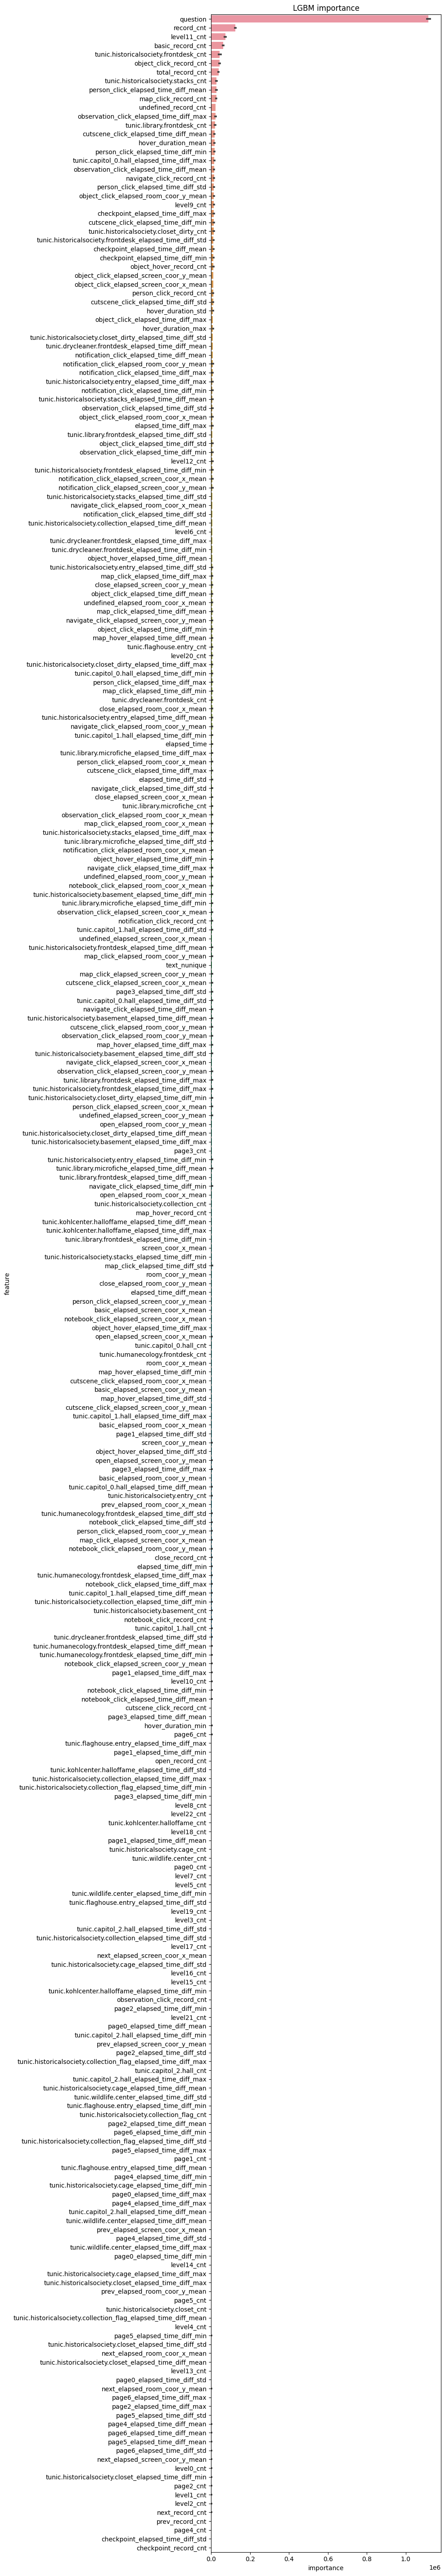

In [14]:
if cfg.mode == "local_cv":
    run_train()
inference(cfg.mode)